In [1]:
import pandas as pd

def check_duplicate_rows(csv_file):
    df = pd.read_csv(csv_file)
    duplicate_rows = df[df.duplicated()]
    if duplicate_rows.empty:
        print("Không có hàng trùng lặp trong tệp CSV.")
    else:
        print("Các hàng trùng lặp trong tệp CSV:")
        print(duplicate_rows)

# Gọi hàm để kiểm tra tệp CSV
check_duplicate_rows('baskets.csv')

Các hàng trùng lặp trong tệp CSV:
       Member_number        Date     itemDescription  year  month  day  \
136             3197  03/01/2014           margarine  2014      1    3   
175             2092  04/01/2014         salty snack  2014      1    4   
263             4628  05/01/2014             napkins  2014      1    5   
299             4694  06/01/2014  whipped/sour cream  2014      1    6   
447             4559  09/01/2014   frozen vegetables  2014      1    9   
...              ...         ...                 ...   ...    ...  ...   
38534           2061  27/12/2015      tropical fruit  2015     12   27   
38535           2061  27/12/2015      tropical fruit  2015     12   27   
38574           4039  27/12/2015    other vegetables  2015     12   27   
38672           2309  29/12/2015          whole milk  2015     12   29   
38762           4565  30/12/2015         canned beer  2015     12   30   

       day_of_week  
136              4  
175              5  
263           

In [2]:
import os
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .appName("midterm") \
    .getOrCreate()

In [ ]:
def read_file(file_path):
    if not os.path.exists(file_path):
        return None
    return spark.sparkContext.textFile(file_path).map(lambda line: line.split(","))

In [ ]:
def visualize(data, title, xlabel, ylabel):
    items, frequencies = zip(*data)
    plt.figure(figsize=(16, 8))
    plt.bar(items, frequencies)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
def save(result, function_name):
    folder_name = function_name.lower()
    file_name = "result.txt"
    folder_path = os.path.join(".", folder_name)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if result is None:
        return

    file_path = os.path.join(folder_path, file_name)

    with open(file_path, 'w') as file:
        if isinstance(result, tuple):
            for item in result:
                file.write(str(item) + '\n')
        elif isinstance(result, list):
            for item in result:
                file.write(str(item) + '\n')
        else:
            file.write(str(result) + '\n')


In [ ]:
def f1(file_path):
    rdd = read_file(file_path)
    if rdd is None:
        return None

    condition = lambda product: product.lower()

    distinct_product_names = rdd.map(lambda basket: basket[2]).distinct()
    distinct_product_names_sorted = distinct_product_names.sortBy(condition, ascending=True).take(10)

    top_ten_bt = distinct_product_names.sortBy(condition, ascending=False).take(10)[::-1]

    return distinct_product_names_sorted, top_ten_bt

In [ ]:
def f2(file_path):
    rdd = read_file(file_path)
    if rdd is None:
        return None

    product_counts = rdd.map(lambda basket: (basket[2], 1)).reduceByKey(lambda a, b: a + b)
    sorted_products = product_counts.sortBy(lambda x: x[1], ascending=False)
    top_100_products = sorted_products.take(100)

    return top_100_products

In [ ]:
def f3(file_path):
    rdd = read_file(file_path)
    if rdd is None:
        return None

    member_baskets = rdd.map(lambda line: ((line[0], line[1]), set(line[2:])))
    member_basket_counts = member_baskets.map(lambda x: (x[0][0], 1)).reduceByKey(lambda a, b: a + b)
    sorted_members = member_basket_counts.sortBy(lambda x: x[1], ascending=False).take(100)

    return sorted_members

In [ ]:
def f4(file_path):
    rdd = read_file(file_path)

    if rdd is None:
        return None

    max_distinct_products_member = rdd.map(lambda line: (line[0], line[2])).groupByKey() \
                    .mapValues(lambda x: len(set(x))) \
                    .max(lambda x: x[1])

    max_members_product = rdd.map(lambda line: (line[2], line[0]))\
                             .groupByKey()\
                             .mapValues(lambda x: len(set(x))).max(lambda x: x[1])

    return max_distinct_products_member[0], max_distinct_products_member[1], max_members_product[0], max_members_product[1]


In [4]:
baskets = "baskets.csv"

In [ ]:
result_f1 = f1(baskets)

if result_f1 is not None:
    print("Top 10 products:\n")
    print("\n".join(result_f1[0]))

    print("\nBottom 10 products:\n")
    print("\n".join(result_f1[1]))

save(result_f1, "f1")

Top 10 products:

abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries
beverages
bottled beer

Bottom 10 products:

UHT-milk
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


In [ ]:
result_f2 = f2(baskets)

if result_f2 is not None:
    print("Top 100 products with their frequencies:")
    for product, frequency in result_f2:
        print(f"{product}: {frequency}")

save(result_f2, "f2")

Top 100 products with their frequencies:
whole milk: 2502
other vegetables: 1898
rolls/buns: 1716
soda: 1514
yogurt: 1334
root vegetables: 1071
tropical fruit: 1032
bottled water: 933
sausage: 924
citrus fruit: 812
pastry: 785
pip fruit: 744
shopping bags: 731
canned beer: 717
bottled beer: 687
whipped/sour cream: 662
newspapers: 596
frankfurter: 580
brown bread: 571
domestic eggs: 566
pork: 566
butter: 534
fruit/vegetable juice: 518
beef: 516
curd: 514
margarine: 491
coffee: 476
frozen vegetables: 425
chicken: 422
white bread: 362
cream cheese : 358
chocolate: 357
dessert: 356
napkins: 335
hamburger meat: 327
berries: 327
UHT-milk: 323
onions: 305
salty snack: 283
waffles: 280
long life bakery product: 269
sugar: 265
butter milk: 263
ham: 256
meat: 254
frozen meals: 252
beverages: 251
specialty chocolate: 240
misc. beverages: 238
ice cream: 227
oil: 225
hard cheese: 220
grapes: 220
candy: 219
sliced cheese: 212
specialty bar: 210
hygiene articles: 208
chewing gum: 181
cat food: 177
wh

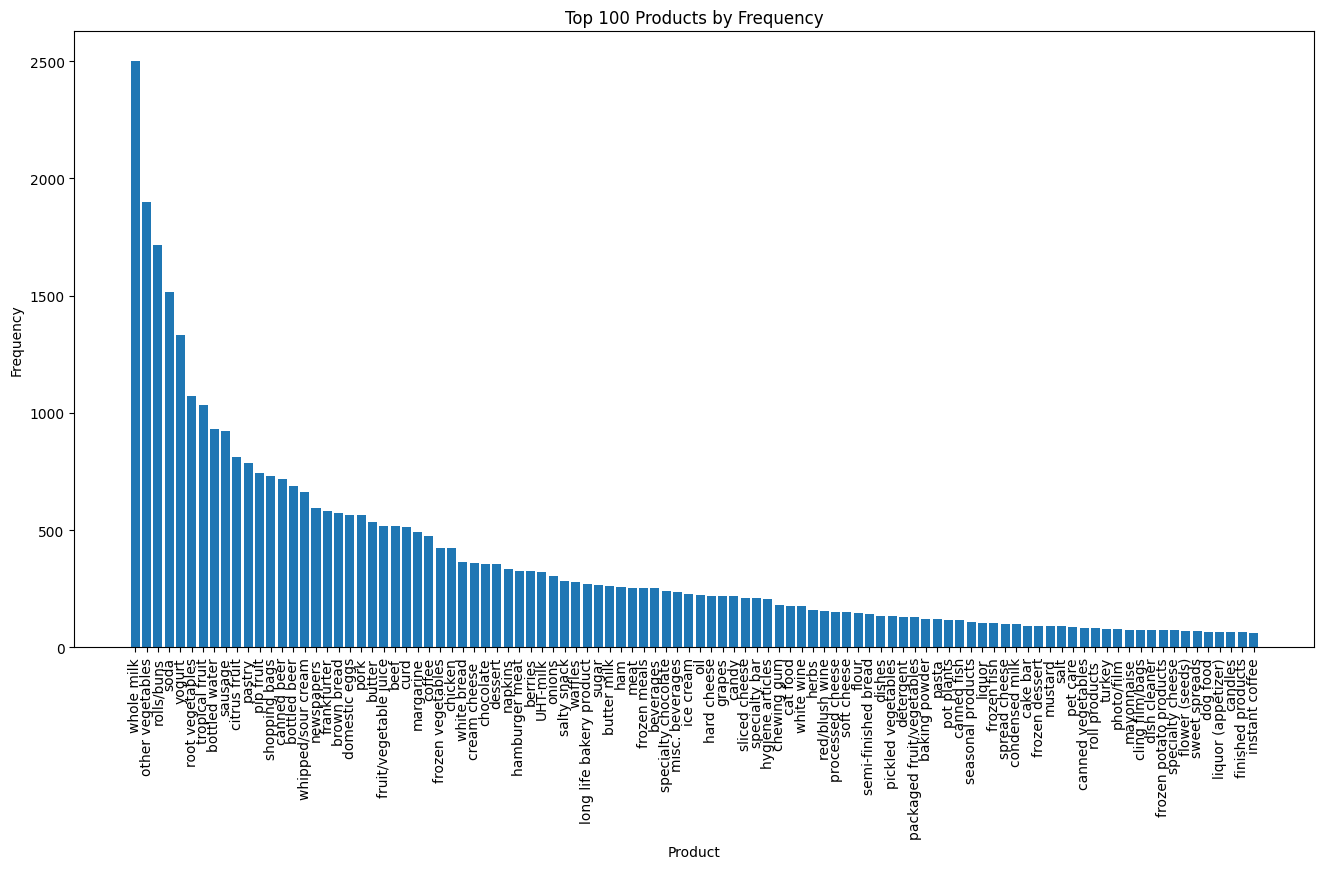

In [ ]:
visualize(result_f2,'Top 100 Products by Frequency', "Product", 'Frequency')

In [ ]:
result_f3 = f3(baskets)

if result_f3 is not None:
    print("Top 100 members with their number of baskets:")
    for member, count in result_f3:
        print(f"Member {member}: {count} baskets")

save(result_f3, "f3")

Top 100 members with their number of baskets:
Member 3180: 36 baskets
Member 3050: 33 baskets
Member 2051: 33 baskets
Member 3737: 33 baskets
Member 2271: 31 baskets
Member 3915: 31 baskets
Member 2625: 31 baskets
Member 2433: 31 baskets
Member 3872: 30 baskets
Member 2851: 29 baskets
Member 2394: 29 baskets
Member 4875: 29 baskets
Member 3289: 29 baskets
Member 2524: 28 baskets
Member 1379: 28 baskets
Member 4338: 28 baskets
Member 3308: 28 baskets
Member 4831: 28 baskets
Member 2517: 27 baskets
Member 4272: 27 baskets
Member 1052: 27 baskets
Member 2663: 27 baskets
Member 1998: 27 baskets
Member 2193: 27 baskets
Member 1410: 27 baskets
Member 3752: 27 baskets
Member 4137: 26 baskets
Member 4376: 26 baskets
Member 1905: 26 baskets
Member 4941: 26 baskets
Member 2960: 26 baskets
Member 3082: 26 baskets
Member 4486: 26 baskets
Member 4695: 26 baskets
Member 2512: 26 baskets
Member 4303: 25 baskets
Member 2164: 25 baskets
Member 2344: 25 baskets
Member 4217: 25 baskets
Member 4864: 25 ba

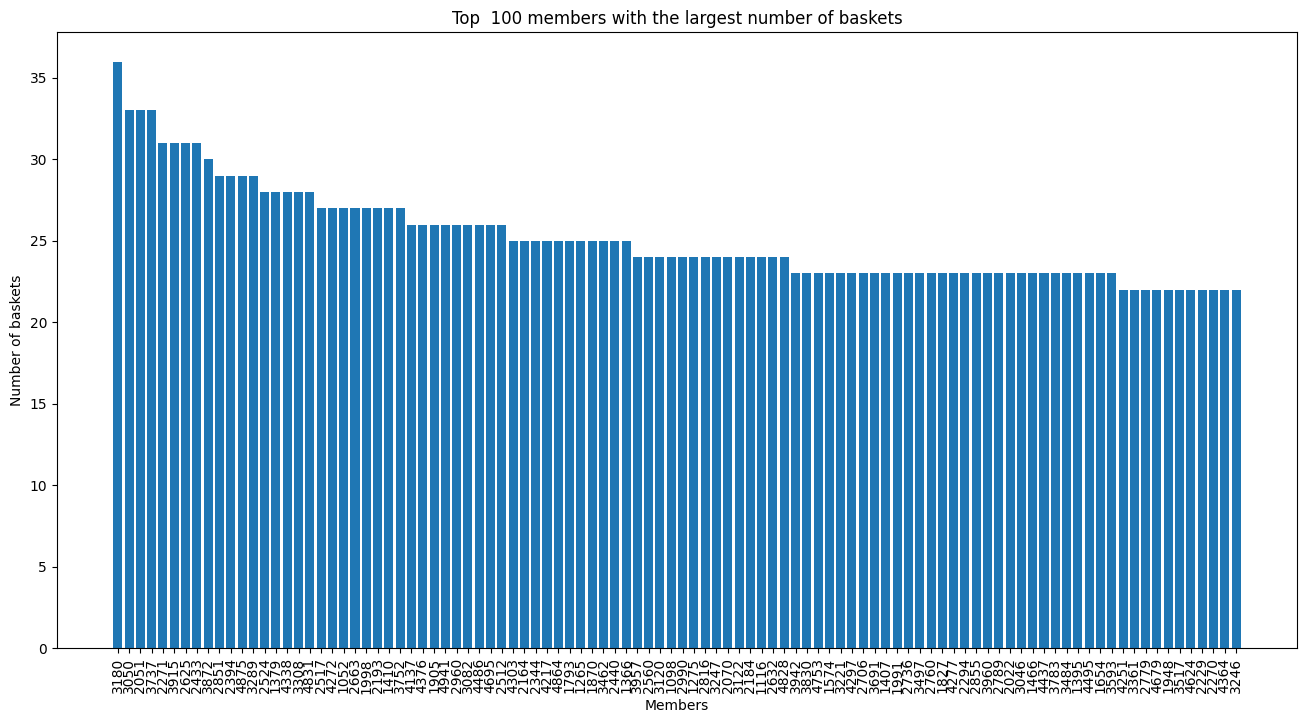

In [ ]:
visualize(result_f3,'Top  100 members with the largest number of baskets', "Members", 'Number of baskets')

In [ ]:
result_f4 = f4(baskets)

if result_f4 is not None:
    print("Member with the largest number of distinct products:")
    print(f"Member: {result_f4[0]}, Number of distinct products: {result_f4[1]}")
    print("\nProduct bought by the most members:")
    print(f"Product: {result_f4[0]}, Number of members: {result_f4[1]}")

save(result_f4, "f4")

Member with the largest number of distinct products:
Member: 2051, Number of distinct products: 26

Product bought by the most members:
Product: 2051, Number of members: 26


# PART 2

In [ ]:
!rm -r /content/baskets

In [5]:
from pyspark.sql.functions import col, collect_list,to_date,collect_set,concat_ws
from itertools import islice

In [6]:
df = spark.read.csv(baskets, header=True, inferSchema=True)
df.show()

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/home/jovyan/code/baskets.csv.

In [ ]:
sorted_baskets_df = df.groupBy("Member_number", "year", "month", "day") \
               .agg(concat_ws(", ", collect_list("itemDescription")).alias("baskets"))\
               .orderBy("year", "month", "day")

sorted_baskets_df.show(truncate=False)

sorted_baskets_df.select("baskets") \
                 .write.mode("overwrite").csv("baskets", header=True)

# sorted_baskets_df.write.option("sep", ";") \
#                 .csv("baskets", header=True)

+-------------+----+-----+---+-----------------------------------------------+
|Member_number|year|month|day|baskets                                        |
+-------------+----+-----+---+-----------------------------------------------+
|1789         |2014|1    |1  |hamburger meat, candles                        |
|2542         |2014|1    |1  |sliced cheese, bottled water                   |
|1249         |2014|1    |1  |citrus fruit, coffee                           |
|1381         |2014|1    |1  |curd, soda                                     |
|1440         |2014|1    |1  |other vegetables, yogurt                       |
|1659         |2014|1    |1  |specialty chocolate, frozen vegetables         |
|1922         |2014|1    |1  |tropical fruit, other vegetables               |
|2226         |2014|1    |1  |sausage, bottled water                         |
|2237         |2014|1    |1  |bottled water, Instant food products           |
|2351         |2014|1    |1  |cleaner, shopping bags

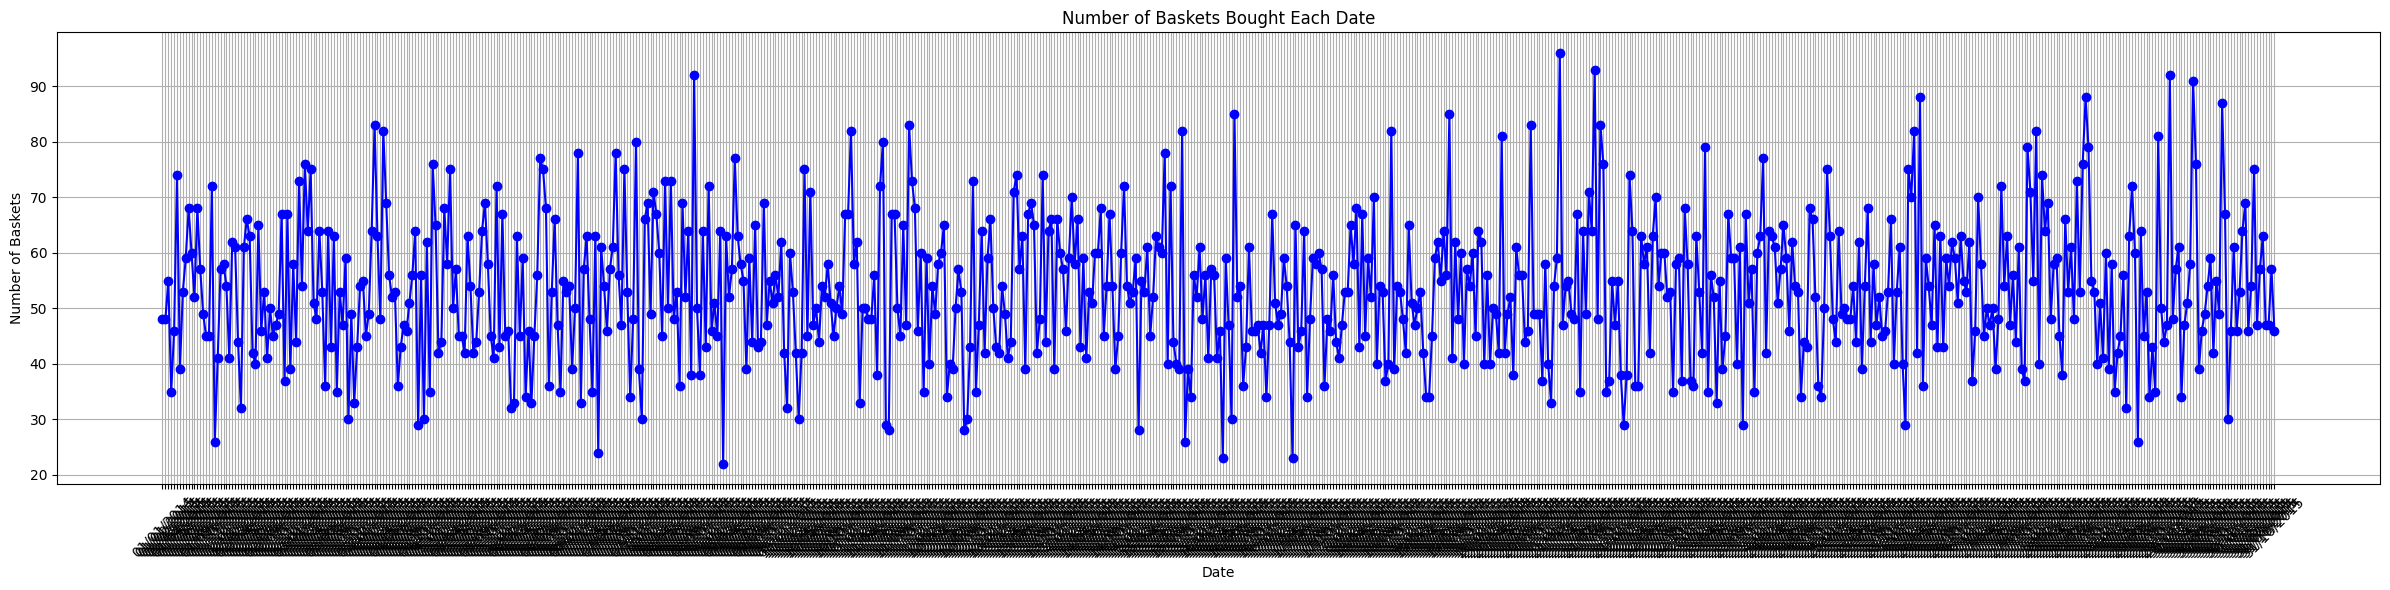

In [ ]:
baskets_count_df = df.groupBy("Date").count().orderBy("Date")
baskets_count_pd = baskets_count_df.toPandas()

baskets_count_pd.to_csv("baskets/result.csv")

# Plotting
plt.figure(figsize=(24, 6))
plt.plot(baskets_count_pd["Date"], baskets_count_pd["count"], marker='o', color='b')
plt.title('Number of Baskets Bought Each Date')
plt.xlabel('Date')
plt.ylabel('Number of Baskets')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!rm -r /content/pcy_frequent_pairs.csv
!rm -r /content/pcy_association_rules.csv

rm: cannot remove '/content/apriori_frequent_pairs.csv': No such file or directory
rm: cannot remove '/content/apriori_association_rules.csv': No such file or directory


In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
import pyspark.sql.functions as F

# Initialize Spark session
from abc import ABC, abstractmethod

class FindRules(ABC):
  def __init__(self,path: str, S: float, C: float):
    self.spark = SparkSession.builder.appName("FindRules").getOrCreate()
    self.sc = self.spark.sparkContext
    self.path=path
    self.S = S
    self.C = C
    self.baskets_df = self.read_baskets()
    self.item = self.baskets_df.select(explode(self.baskets_df["baskets"]) \
                                    .alias("item"))
    self.total_baskets = self.baskets_df.count()

  @abstractmethod
  def run(self):
    pass

  def read_baskets(self):
    # Read baskets from CSV file
    baskets_df = self.spark.read.csv(self.path,
                                     header=True,
                                     inferSchema=True,
                                     sep=';')

    baskets_df = baskets_df.withColumn("baskets",
                                       F.split(baskets_df["baskets"], ","))
    return baskets_df

  def _save(self, df: DataFrame, destination: str):
        df.write.mode("overwrite").option("sep", ";").csv(destination, header=True)

  def __delete__(self):
    self.spark.stop()


In [ ]:
class APriori(FindRules):
    def find_frequent_items(self):
        # Count the occurrences of itemsets in the baskets
        itemset_counts = self.item.groupBy('item') \
                                            .agg(count('*').alias('count'))
        # Calculate support by dividing the count of itemsets by the total number of baskets
        support_df = itemset_counts.withColumn('support', itemset_counts['count'] / self.total_baskets)

        frequent_items_df = support_df.filter(support_df['support'] >= self.S)

        return frequent_items_df

    def _generate_pairs(self, frequent_items_df):
        # Generate candidate pairs from frequent items
        combinations_df = frequent_items_df.crossJoin(frequent_items_df.withColumnRenamed('item', 'item2'))

        # Create two separate columns for item1 and item2
        pairs = combinations_df \
            .filter(combinations_df["item"] < combinations_df["item2"]) \
            .withColumnRenamed('item', 'item1') \
            .select("item1", "item2")
        return pairs

    def generate_frequent_pairs(self,frequent_items_df):
        pairs = self._generate_pairs(frequent_items_df)
        basket = self.baskets_df.select('Basket')

        tmp_tb = basket.crossJoin(pairs)

        frequent_pairs = tmp_tb.filter(array_contains(tmp_tb["baskets"], tmp_tb["item1"]) &
                                        array_contains(tmp_tb["baskets"], tmp_tb["item2"])) \
                                .groupBy(tmp_tb["item1"],tmp_tb["item2"]) \
                                .count() \
                                .withColumnRenamed("count", "freq") \
                                .selectExpr("array(item1, item2) as items", "freq")

        return frequent_pairs

    def _generate__rule(self, frequent_items_df, frequent_pairs, i,j):
      # Calculate support and confidence
        assoc_rules_df = frequent_pairs.select(
            frequent_pairs['items'][i].alias('antecedent'),
            frequent_pairs['items'][j].alias('consequent'),
            frequent_pairs['freq']
        ).withColumn(
            'support',
            col('freq') / self.total_baskets
        )

        # Join assoc_rules_df with frequent_items_df to get support for antecedents
        assoc_rules_df = assoc_rules_df.join(
            broadcast(frequent_items_df),
            on=(assoc_rules_df['antecedent'] == frequent_items_df['item']),
            how='inner'
        ).select(
            'antecedent',
            'consequent',
            'freq',
            assoc_rules_df['support'].alias('support'),
            frequent_items_df['support'].alias('antecedent_support')
        )

        # Calculate confidence
        assoc_rules_df = assoc_rules_df.withColumn(
            'confidence',
            col('support') / col('antecedent_support')
        )

        assoc_rules_df = assoc_rules_df.drop('antecedent_support', 'freq')

        return assoc_rules_df


    def generate_association_rules(self, frequent_items_df, frequent_pairs):
        assoc_rules_1 = self._generate__rule(frequent_items_df,frequent_pairs,0,1)
        assoc_rules_2 = self._generate__rule(frequent_items_df,frequent_pairs,1,0)
        unioned_df = assoc_rules_1.union(assoc_rules_2)

        return unioned_df.filter(unioned_df.support >= self.S) \
                          .filter(unioned_df.confidence >= self.C)

    def run(self):
        frequent_items_df = self.find_frequent_items()
        frequent_pairs = self.generate_frequent_pairs(frequent_items_df)
        association_rules = self.generate_association_rules(frequent_items_df, frequent_pairs)

        print('='*15 + 'Apriori' + '='*15)
        print("Frequent Itemsets:")
        frequent_pairs.show(truncate=False)
        print("\nFiltered Association Rules:")
        association_rules = association_rules.orderBy(col("antecedent"), col("consequent"))
        association_rules.show(truncate=False)

        # Prepare data to save
        frequent_pairs = frequent_pairs.withColumn("items",
                                      F.concat_ws(
                                          ",", col("items")
                                      ))

        # save to file
        self._save(frequent_pairs,'apriori_frequent_pairs.csv')
        self._save(association_rules,'apriori_association_rules.csv')



In [ ]:
from pyspark.sql.types import StructType, StructField, ArrayType, StringType, IntegerType

class PCY(APriori):
    def __init__(self,path: str, S: float, C: float, bucket_size: int = 1000):
        super().__init__(path,S,C)
        self.bucket_size = bucket_size

    def generate_frequent_pairs(self, frequent_items_df):
        pairs = self._generate_pairs(frequent_items_df)
        pairs = pairs.withColumn('hash_value', abs(hash(concat_ws('\t',*pairs.columns)) % self.bucket_size))

        hash_df = pairs.select(pairs['hash_value']) \
                      .groupBy(pairs['hash_value']) \
                        .count()

        basket = self.baskets_df.select('baskets')


        hash_df = hash_df.filter((col("count") / self.total_baskets) >= self.S)
        hash_dict = hash_df.rdd.collectAsMap()
        if not hash_dict:
          schema = StructType([
                                  StructField("items", ArrayType(StringType(), True), True),
                                  StructField("freq", IntegerType(), True)
                              ])
          return self.spark.createDataFrame([], schema)
        tmp_tb = basket.crossJoin(pairs)

        frequent_pairs = tmp_tb.filter(expr('hash_value IN ({})'.format(','.join(map(str, hash_dict))))) \
                                .filter(array_contains(tmp_tb["baskets"], tmp_tb["item1"]) &
                                        array_contains(tmp_tb["baskets"], tmp_tb["item2"])) \
                                .groupBy(tmp_tb["item1"], tmp_tb["item2"]) \
                                .count() \
                                .withColumnRenamed("count", "freq") \
                                .selectExpr("array(item1, item2) as items", "freq")

        return frequent_pairs

    def run(self):
        frequent_items_df = self.find_frequent_items()
        frequent_pairs = self.generate_frequent_pairs(frequent_items_df)
        association_rules = self.generate_association_rules(frequent_items_df, frequent_pairs)

        print('=' * 15 + 'PCY' + '=' * 15)
        print("Frequent Itemsets:")
        frequent_pairs.show(truncate=False)
        print("\nFiltered Association Rules:")
        association_rules = association_rules.orderBy(col("antecedent"), col("consequent"))
        association_rules.show(truncate=False)

        # Prepare data to save
        frequent_pairs = frequent_pairs.withColumn("items",
                                                  F.concat_ws(
                                                      ",", col("items")
                                                  ))

        # save to file
        self._save(frequent_pairs, 'pcy_frequent_pairs.csv')
        self._save(association_rules, 'pcy_association_rules.csv')


In [ ]:
pcy = PCY('/content/baskets',S = 2E-4, C = .3)
pcy.run()

===============PCY===============
Frequent Itemsets:
+----------------------------------------------+----+
|items                                         |freq|
+----------------------------------------------+----+
|[ canned vegetables, beverages]               |1   |
|[ canned vegetables, cat food]                |1   |
|[ canned vegetables,  cream cheese ]          |1   |
|[ canned vegetables, napkins]                 |1   |
|[ canned vegetables,  pork]                   |1   |
|[ canned vegetables, meat]                    |1   |
|[ canned vegetables, white wine]              |2   |
|[ canned vegetables, frankfurter]             |2   |
|[ canned vegetables, long life bakery product]|2   |
|[ canned vegetables,  salty snack]            |1   |
|[ canned vegetables,  fruit/vegetable juice]  |1   |
|[ canned vegetables, yogurt]                  |1   |
|[ canned vegetables,  sliced cheese]          |1   |
|[ canned vegetables,  pot plants]             |1   |
|[ canned vegetables, roll pr